In [1]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging 

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
    OneHotEncoder
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer,
)

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)
pd.options.display.max_columns = None
pd.options.display.max_rows = None

logging.basicConfig(level=logging.INFO, format='%(asctime)s:%(levelname)s:%(message)s')

# Config

In [26]:
# columns to read

RANDOM_SEED = 42

DF_COLUMNS = ["sewage_company", "altitude", "postcode_area",
              "new_build", "type", "ward", "constituency", "price"]


# ['type',
#               'constituency',
#               'postcode_district',
#               'average_income',
#               'region_name',
#               'area_code',
#               'year',
#              'price']

# categorical variables with NA in train set
CATEGORICAL_VARS_WITH_NA_FREQUENT = []


CATEGORICAL_VARS_WITH_NA_MISSING = []


# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = []


TEMPORAL_VARS = []


# variables to log transform
NUMERICALS_LOG_VARS = []

DROP_VARS = []


# onehot encode
ONE_HOT_VARS = ["new_build", "type", "ward"]

# categorical variables to encode
CATEGORICAL_VARS = [
       'constituency', "sewage_company",
       "postcode_area"
       ]

# [
#        'constituency', 'postcode_district',
#        'region_name', 'area_code'
#        ]

In [27]:
# load dataset
data = pd.read_csv('../zanasonic/datasets/processed/pp_nottinghamshire.csv', usecols=DF_COLUMNS)

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(380989, 8)


,price,type,new_build,ward,constituency,postcode_area,sewage_company,altitude
0,53000,D,N,Eastwood Hilltop,Ashfield,NG,NaN,106.0
1,28000,T,N,Aspley,Nottingham North,NG,NaN,88.0
2,67000,D,N,Sutton-on-Trent,Newark,NG,NaN,17.0
3,33500,S,N,Bilborough,Nottingham North,NG,NaN,68.0
4,45000,S,N,Holly,Mansfield,NG,NaN,123.0


In [24]:
data.isna().sum()

type                   0
new_build              0
ward                   0
constituency           0
postcode_area          0
sewage_company    379666
altitude               0
dtype: int64

In [28]:

# Split the data - train, validation and test
train_set, test_set = train_test_split(data,
                                       test_size=0.30,
                                       random_state=RANDOM_SEED)

test_set, validation_set = train_test_split(test_set,
                                            test_size=0.20,
                                            random_state=RANDOM_SEED)

# # load the pre-selected features
# # ==============================

X_train = train_set.drop('price', axis = 1)
X_test = validation_set.drop('price', axis = 1)

y_train = train_set['price']
y_test = validation_set['price']

logging.info(f"Training shape: {train_set.shape}")
logging.info(f"Validation shape: {validation_set.shape}")
logging.info(f"Test shape: {test_set.shape}")

# Save the split files
# train_set.to_csv("../data/processed/train.csv", index=False)
# validation_set.to_csv("../data/processed/validation.csv", index=False)
# test_set.to_csv("../data/processed/test.csv", index=False)

2021-07-17 18:37:54,627:INFO:Training shape: (266692, 8)
2021-07-17 18:37:54,628:INFO:Validation shape: (22860, 8)
2021-07-17 18:37:54,629:INFO:Test shape: (91437, 8)


In [29]:
X_train.head(2)

,type,new_build,ward,constituency,postcode_area,sewage_company,altitude
111297,D,N,Bingham West,Newark,NG,NaN,29.0
175648,S,N,Compton Acres,Rushcliffe,NG,NaN,46.0


In [35]:
# set up the pipeline
transform_pipeline = Pipeline([

     # ===== IMPUTATION =====
    # impute categorical variables with string missing
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING)),

    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),

    # add missing indicator
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),

    # impute numerical variables with the mean
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA
    )),

    #('drop_features', DropFeatures(features_to_drop=DROP_VARS)),

    # ==== VARIABLE TRANSFORMATION =====
    #('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
    
    ('one_hot_encode', OneHotEncoder(top_categories=None, variables=ONE_HOT_VARS, drop_last=True)),

    # == CATEGORICAL ENCODING
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=3, variables=CATEGORICAL_VARS
    )),

    # encode categorical and discrete variables using the target mean
    ('categorical_encoder', OrdinalEncoder(
         encoding_method='ordered', variables=CATEGORICAL_VARS)),
     ('scaler', MinMaxScaler()),
])

In [36]:
model_pipeline = Pipeline(steps=[('preparation_pipeline', transform_pipeline),
                                 ('model', RandomForestRegressor())
                                ])

In [37]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preparation_pipeline',
                 Pipeline(steps=[('missing_imputation',
                                  CategoricalImputer(variables=[])),
                                 ('frequent_imputation',
                                  CategoricalImputer(imputation_method='frequent',
                                                     variables=[])),
                                 ('missing_indicator',
                                  AddMissingIndicator(variables=[])),
                                 ('mean_imputation',
                                  MeanMedianImputer(imputation_method='mean',
                                                    variables=[])),
                                 ('one_hot_encode',
                                  O...coder(drop_last=True,
                                                variables=['new_build', 'type',
                                                           'ward'])),
                                 ('rare

In [38]:
# evaluate the model:
# ====================

# make predictions for train set
pred = model_pipeline.predict(X_train)


# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(y_train, pred))))
print('train rmse: {}'.format(int(
    mean_squared_error(y_train, pred, squared=False))))
print('train r2: {}'.format(
    r2_score(y_train, pred)))
print()


/Users/chris/github/zanalytics/repositories/zanasonic/.venv/lib/python3.9/site-packages/feature_engine/encoding/one_hot.py:275: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(


train mse: 3720456304
train rmse: 60995
train r2: 0.528235673027099



In [47]:
X_test["type"].value_counts()

S    8329
D    8190
T    5083
F    1102
O     156
Name: type, dtype: int64

In [42]:
# make predictions for test set
pred = model_pipeline.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(y_test, pred))))
print('test rmse: {}'.format(int(
    mean_squared_error(y_test, pred, squared=False))))
print('test r2: {}'.format(
    r2_score(y_test, pred)))
print()

print('Average house price: ', int(y_train.median()))

/Users/chris/github/zanalytics/repositories/zanasonic/.venv/lib/python3.9/site-packages/feature_engine/encoding/one_hot.py:275: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(


test mse: 4300116556
test rmse: 65575
test r2: 0.4586521460209044

Average house price:  110000


/Users/chris/github/zanalytics/repositories/zanasonic/.venv/lib/python3.9/site-packages/feature_engine/encoding/one_hot.py:275: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(


Text(0.5, 1.0, 'Evaluation of Random Forest Predictions')

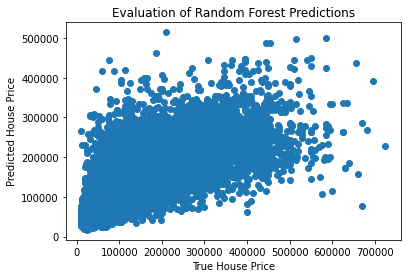

In [43]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, model_pipeline.predict(X_test))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Random Forest Predictions')